In [70]:
# Import public packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
from scipy.stats import spearmanr, pearsonr
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [79]:
mv_eve = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200717-rd2-em1-zmv-04.pkl')
mv_eve2 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/20200811-em1-zsmv-06.pkl')


In [52]:
mv_hb = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/2020-07-29-em5-zsmv-01.pkl')

In [4]:
mv_sna = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/2020-08-16-em1-zsmv-01.pkl')
mv_sna2 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/2020-08-16-em1-zsmv-03.pkl')


In [5]:
from skimage.filters.thresholding import threshold_li, threshold_otsu

def mask_rpb1_foci(stack, mask, sigma1=3, dilation_len=10):
    """Mask Rpb1 foci within nuclei"""
    mask_foci = np.zeros_like(stack)
    for i in range(0, stack.shape[0]):
        maxp = stack[i].max(axis=0)
        im_smooth = ndi.filters.gaussian_filter(maxp, sigma=sigma1)
        # Make second mask of pol2 foci (presumed HLBs) by re-thresholding within nuclei.
        t_foci = threshold_otsu(im_smooth[mask[i,0].astype('bool')])
        mask_2d = np.where(im_smooth > t_foci, True, False)
        mask_2d = ndi.morphology.binary_dilation(mask_2d, structure=np.ones((dilation_len, dilation_len)))
        mask_3d = np.repeat([mask_2d], stack.shape[1], axis=0)
        mask_foci[i] = mask_3d
    return mask_foci.astype('bool')

#a=mask_rpb1_foci(mv.stack[0], mv.nucmask)

In [6]:
from random import random
def random_spot_data(spot_data, mask, n):
    """Produce spot_data for spots in random positions within nuclei, constrained by HLB mask"""
    rand_spot_data = {}
    for spot in spot_data:
        rand_spot_data[spot] = np.ndarray((spot_data[spot].shape[0] * n, spot_data[spot].shape[1]))
        rownum=0
        arr = spot_data[spot]
        for row in arr:
            t, nuc, z = [int(x) for x in row[0:3]]
            x,y = np.where(mask[t,z] == nuc)
            numpix = len(x)
            for i in range(0, n):
                rand = int(numpix * random())
                randx, randy = x[rand], y[rand]
                newrow = row.copy()
                newrow[3:5] = [randx, randy]
                rand_spot_data[spot][rownum] = newrow
                rownum = rownum + 1
    return rand_spot_data
#e=random_spot_data(mv.spot_data, np.where(a, 0, mv.nucmask),2)

In [7]:
def project(x):
    x1 = x[:,:,2:5].sum(axis=2).sum(axis=1).sum(axis=0)
    return x1

In [26]:
mv = mv_eve
hlb_mask = mask_rpb1_foci(mv.stack[0], mv.nucmask)
nucmask_masked = np.where(hlb_mask, 0, mv.nucmask)
rand_data = random_spot_data(mv.spot_data, nucmask_masked, 5)
true_ms2 = imp.spot_movies(mv.stack, mv.spot_data, channel=1, fill=0, len_ij=31, view=False)
true_prot = imp.spot_movies(mv.stack, mv.spot_data, channel=0, fill=0, len_ij=31, view=False)
rand_ms2 = imp.spot_movies(mv.stack, rand_data, channel=1, fill=0, len_ij=31, view=False)
rand_prot = imp.spot_movies(mv.stack, rand_data, channel=0, fill=0, len_ij=31, view=False)

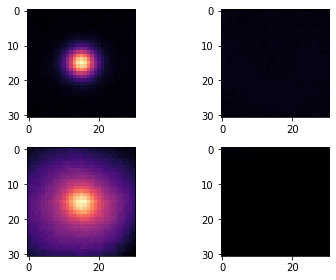

In [117]:
fig, ax = plt.subplots(2,2)
tm = project(true_ms2)
rm = project(rand_ms2)
tp = project(true_prot)
rp = project(rand_prot)

ax[0][0].imshow(tm,cmap="magma", vmax=tm.max(), vmin=tm.min())
ax[0][1].imshow(rm,cmap="magma", vmax=tm.max(), vmin=tm.min())
ax[1][0].imshow(tp,cmap="magma", vmax=tp.max(), vmin=tp.min())
ax[1][1].imshow(rp,cmap="magma", vmax=tp.max(), vmin=tp.min())
fig.tight_layout()

#ax[0][0].set_title('test')

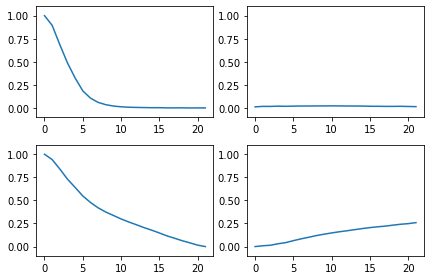

In [122]:
fig, ax = plt.subplots(2,2)
r_tm = radial(tm)
r_rm = radial(rm)
r_tp = radial(tp)
r_rp = radial(rp)

def norm(a,b):
    min_ = min([b.min(), a.min()])
    return (a - min_) / (b.max() - min_)

ax[0][0].plot(np.arange(0, len(r_tm)), norm(r_tm, r_tm))
ax[0][0].set_ylim(-0.1,1.1)
ax[0][1].plot(np.arange(0, len(r_rm)), norm(r_rm, r_tm))
ax[0][1].set_ylim(-0.1,1.1)
ax[1][0].plot(np.arange(0, len(r_tp)), norm(r_tp, r_tp))
ax[1][0].set_ylim(-0.1,1.1)
ax[1][1].plot(np.arange(0, len(r_rp)), norm(r_rp, r_tp))
ax[1][1].set_ylim(-0.1,1.1)

fig.tight_layout()

#ax[0][0].set_title('test')

In [27]:
ss_m = project_singlespots(true_ms2)
ss_p = project_singlespots(true_prot)
viewer([ss_p, ss_m],6)

interactive(children=(Dropdown(description='Color', index=3, options=('gray_r', 'magma', 'gray', 'Greens', 'in…

SpearmanrResult(correlation=array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,  1.        ,
        -0.31558442, -0.35974026],
       [        nan,         nan,         nan, ..., -0.31558442,
         1.        ,  0.35974026],
       [        nan,         nan,         nan, ..., -0.35974026,
         0.35974026,  1.        ]]), pvalue=array([[0.00000000e+00, 1.57789759e-03, 3.74397763e-03, ...,
        2.62972942e-01, 4.03591538e-03, 5.55595356e-01],
       [1.57789759e-03, 0.00000000e+00, 1.32810596e-01, ...,
        2.88804254e-01, 1.94868944e-04, 1.13384909e-01],
       [3.74397763e-03, 1.32810596e-01, 0.00000000e+00, ...,
        3.33280520e-01, 1.59826896e-01, 8.27404666e-01

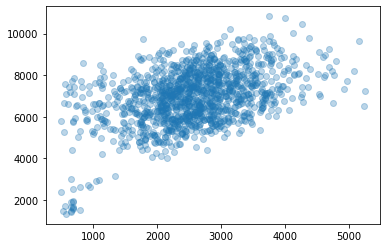

In [35]:
plt.scatter(mv_sna.intvol, mv_sna.prot, alpha=0.3);
spearmanr(mv_sna.intvol, mv_sna.prot)

In [120]:
r_rp.max()

12318132.25

In [74]:
def radial(data):
    x,y, = imp.mesh_like(data, 2)
    cenx = int(data.shape[0] / 2)
    ceny = int(data.shape[0] / 2)
    dist = np.sqrt(((x - cenx)**2) + ((y - ceny)**2))
    sums = np.zeros(int(dist.max()) + 1)
    counts = np.zeros(int(dist.max()) + 1)
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            dist_bin = int(dist[i,j])
            sums[dist_bin] = sums[dist_bin] + data[i,j]
            counts[dist_bin] = counts[dist_bin] + 1
    return sums / counts

In [22]:
def project_singlespots(x):
    x1 = x[:,:,3:4].sum(axis=2).sum(axis=1)
    return x1

SpearmanrResult(correlation=0.39516563609877825, pvalue=1.0044865666382051e-49)
(0.4544735257027091, 4.238436337779684e-67)


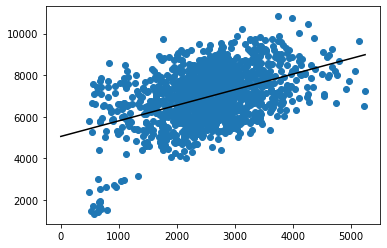

In [84]:
def plot_vs(data1, data2, maxval=np.inf):
    data1 = data1.copy()
    data2 = data2.copy()
    data1 = data1.to_numpy().flatten()
    data2 = data2.to_numpy().flatten()
    data1 = data1[~np.isnan(data1)]
    data2 = data2[~np.isnan(data2)]
    data1 = data1[data2 <= maxval]
    data2 = data2[data2 <= maxval]
    m, b = np.polyfit(data1, data2, 1)
    x = np.arange(0, data1.max())
    plt.scatter(data1, data2, alpha=1)
    plt.plot(x, m*x + b, color="black")
    print(spearmanr(data1, data2))
    print(pearsonr(data1, data2))

plot_vs(mv_sna.intvol, mv_sna.prot, np.inf)

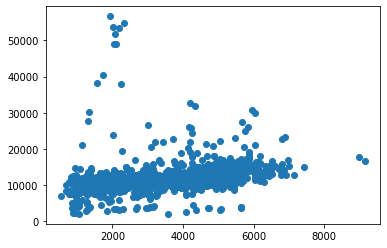

In [58]:
plt.scatter(data1, data2)
plt.plot(np.arange(0,1e4,1))